In [1]:
from PINN import PINN
from dataloader import DataloaderEuropean1D
import torch

import logging
from datetime import datetime

N_EPOCH = 4_000
LEARNING_RATE = 1e-5
HIDDEN_LAYER = 6
HIDDEN_WIDTH = 256
N_sample = 8000
PHYSICS_PENALTY = 52
BVP1_PENALTY = 8
DEVICE = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

K = 40
r = 0.05
sigma = 0.2
T = 1
S_range = [0, 160]
t_range = [0, T]

euro_call_data = DataloaderEuropean1D(t_range, S_range, K, r, sigma, DEVICE)


ModuleNotFoundError: No module named 'PINN'

In [ ]:
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}


In [1]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_expiry_time_tensor(N_sample,r_ivp)
    print(ivp_y_tensor)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_boundary_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_pde_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS) - (r * y1_hat)
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    

In [ ]:
import pandas as pd

In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")
plt.show()

In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8, subplots = True)
plt.sup_title("Training Curve for Moving Average of losses")
plt.show()

In [1]:
from dataloader import DataloaderEuropeanMultiDimensional
import numpy as np
import torch

S_range = np.array([[0, 100] for i in range(5)])
sigma = np.ones((5,5))

DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
tmp = DataloaderEuropeanMultiDimensional((0,1), S_range, 40, 0.04, sigma, DEVICE)

expiry_x_tensor_validation, expiry_y_tensor_validation = tmp.get_expiry_time_tensor(100, 1)
lower_x_tensor_validation, lower_y_tensor_validation, upper_x_tensor_validation, upper_y_tensor_validation = tmp.get_boundary_data_tensor(
        100, 1, 1)

(100, 5) (100,)


In [7]:
X1_validation, y1_validation = tmp.get_pde_data_tensor(100)

In [14]:
X1_validation = tmp.normalize(X1_validation)

In [15]:
X1_validation

tensor([[5.5663e-01, 8.1341e-09, 4.1964e-11, 2.9241e-09, 7.5798e-09, 5.5770e-10],
        [4.1556e-01, 7.7526e-09, 1.7014e-09, 6.8793e-09, 3.8662e-09, 3.7728e-09],
        [9.3572e-01, 2.1513e-09, 2.1051e-09, 1.4532e-09, 2.8738e-09, 4.8232e-09],
        ...,
        [1.5449e-01, 8.6376e-09, 3.8075e-09, 3.3131e-09, 6.8274e-09, 7.4996e-09],
        [7.0939e-01, 5.8827e-09, 3.0858e-09, 2.6161e-09, 1.8501e-09, 5.7526e-09],
        [3.0809e-01, 8.6357e-09, 6.4263e-09, 8.7611e-09, 2.0702e-09, 2.7276e-09]],
       device='cuda:3', grad_fn=<DivBackward0>)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
X = np.load("results/average_loss_different_loss.npy")
X.shape

(60, 6)

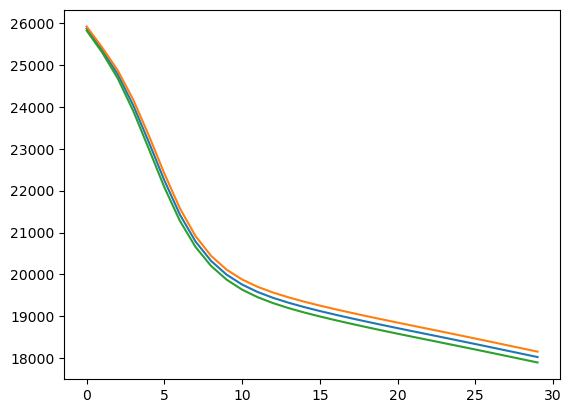

In [23]:
types_of_loss = ["total_loss"] #"loss_boundary","loss_pde", "loss_expiry", "loss_lower", "loss_upper"]
for idx, i in enumerate(types_of_loss, 5):
    plt.plot(X[:30, idx])
    plt.plot(X[:30, idx] + X[30:, idx])
    plt.plot(X[:30, idx] - X[30:, idx])

In [1]:
import torch 
from src.data_generator import DataGeneratorEuropean1D
import rff
import numpy as np

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloader = DataGeneratorEuropean1D([0,1], [0,200], 40, 0.05, 0.5, DEVICE)

In [22]:
X, y1 = dataloader.get_pde_data_tensor(128)
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=256).to(DEVICE)
X_e = encoding(X)
print(X_e.shape)
X = dataloader.normalize(X)
X_s = encoding(X)
print(X_s)

torch.Size([512, 512])
tensor([[ 0.9623, -0.7520,  0.4325,  ..., -0.2591,  0.4436, -0.4068],
        [-0.3626, -0.0775,  0.8922,  ...,  0.6082, -0.9982,  0.4729],
        [-0.2495,  0.0128, -0.5680,  ...,  0.8744,  0.8377, -0.7791],
        ...,
        [-0.8124,  0.8526,  0.1969,  ...,  0.9937, -0.6033,  0.3014],
        [-0.9690, -0.8544, -0.9650,  ...,  0.4225,  0.7546,  0.4545],
        [ 0.8126,  0.1543, -0.9103,  ..., -0.9858,  0.3133,  0.8480]],
       device='cuda:0', grad_fn=<CatBackward0>)


In [14]:
import matplotlib.pyplot as plt

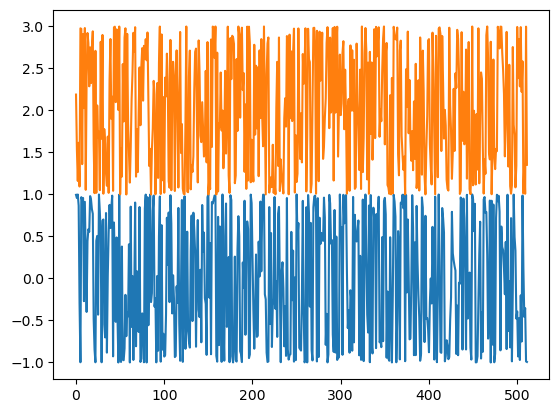

In [19]:
plt.plot(X_e[:,0].to("cpu").detach())
plt.plot(X_s[:,0].to("cpu").detach() + 2)

In [21]:
print(torch.max(X_e), torch.min(X_e))
print(torch.max(X_s), torch.min(X_s))

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)


In [9]:
import numpy as np
X1 = np.loadtxt("results/mse_data_with_fourier.txt")
print(f"{X1.mean():e}")
print(f"{X1.std():e}")
print(f"{X1.max():e}")

3.110521e-03
2.988741e-04
3.712181e-03


In [6]:
X2 = np.loadtxt("results/rmse_data_no_fourier.txt")
print(f"{X2.mean():e}")
print(f"{X2.std():e}")

9.045288e-03
1.435590e-03


In [11]:
(X2.mean() / X1.mean())**2

8.456264683615409